# Pryngles module: Science

In [2]:
from pryngles import *

## External modules

In [50]:
import numpy as np
import math as mh
import spiceypy as spy
from scipy.integrate import quad

## The Science class

The Science class is a class with routines intended to perform a wide diversity of mathematical, physical and astronomical calculations.

In [4]:
class Science(PrynglesCommon):pass

### Template method

In [5]:
def template(foo=1):
    """
    Method

    Parameters:

        foo: type [units], default = 1:
            Description.

    Return:

        fee: type [units]:
            Desctiption.

    """
    return foo

Science.template=template

In [6]:
if IN_JUPYTER:
    def test_temp(self):
        
        #Test
        Science.template()
        """
        self.assertEqual(self.P.Nr,8,True)
        self.assertEqual(np.isclose([P.physics.wrot],
                                    [2*np.pi/PlanetDefaults.physics["prot"]],
                                    rtol=1e-7),
                         [True]*1)
        self.assertRaises(AssertionError,lambda:Observer(primary="Nada"))
        """
        
    class Test(unittest.TestCase):pass
    Test.test_temp=test_temp
    unittest.main(argv=['first-arg-is-ignored'],exit=False)

.
----------------------------------------------------------------------
Ran 1 test in 0.001s

OK


### Cartesian to spherical

In [7]:
def spherical(xyz):
    """
    Transform cartesian coordinates into spherical coordinates

    Parameters:

        xyz: array (3):
            Cartesian coordinates

    Return:

        rqf: array (3):
            Spherical coordinates (r, theta, phi) where theta is azimutal angle and phi is 
            elevation (complement of polar angle).                

            Notice that this convention is different than that of regular vectorial calculus
            where spherical coordinates are (r,theta,phi), but theta is the polar angle and phi 
            the ezimutal one.

    """
    r,theta,phi=spy.reclat(np.array(xyz))
    theta=2*mh.pi+theta if theta<0 else theta

    return np.array([r,theta,phi])

def cartesian(rqf):
    """
    Transform cartesian coordinates into spherical coordinates

    Parameters:

        xyz: array (3):
            Cartesian coordinates

    Return:

        rqf: array (3):
            Spherical coordinates (r, theta, phi) where theta is azimutal angle and phi is 
            elevation (complement of polar angle).                

            Notice that this convention is different than that of regular vectorial calculus
            where spherical coordinates are (r,theta,phi), but theta is the polar angle and phi 
            the ezimutal one.

    """
    return spy.latrec(rqf[0],rqf[1],rqf[2])

Science.spherical=spherical
Science.cartesian=cartesian

In [8]:
if IN_JUPYTER:
    def test_coords(self):
        
        #Test spherical
        rqf=Science.spherical([1,1,0])
        print(rqf[0],rqf[1]*Consts.rad,rqf[2]*Consts.rad)   
        rqf=Science.spherical([+1,+1,1])
        print(rqf[0],rqf[1]*Consts.rad,rqf[2]*Consts.rad)   
        rqf=Science.spherical([-1,1,1])
        print(rqf[0],rqf[1]*Consts.rad,rqf[2]*Consts.rad)   
        rqf=Science.spherical([-1,-1,1])
        print(rqf[0],rqf[1]*Consts.rad,rqf[2]*Consts.rad)   
        rqf=Science.spherical([+1,-1,1])
        print(rqf[0],rqf[1]*Consts.rad,rqf[2]*Consts.rad)   
        rqf=Science.spherical([+1,+1,-1])
        print(rqf[0],rqf[1]*Consts.rad,rqf[2]*Consts.rad)   
        rqf=Science.spherical([-1,1,-1])
        print(rqf[0],rqf[1]*Consts.rad,rqf[2]*Consts.rad)   
        rqf=Science.spherical([-1,-1,-1])
        print(rqf[0],rqf[1]*Consts.rad,rqf[2]*Consts.rad)   
        rqf=Science.spherical([+1,-1,-1])
        print(rqf[0],rqf[1]*Consts.rad,rqf[2]*Consts.rad)
        
        #Test cartesian
        xyz=Science.cartesian([1,0,0])
        print(xyz) 
        xyz=Science.cartesian([1,45*Consts.deg,45*Consts.deg])
        print(xyz) 
        xyz=Science.cartesian([1,135*Consts.deg,45*Consts.deg])
        print(xyz) 
        xyz=Science.cartesian([1,225*Consts.deg,45*Consts.deg])
        print(xyz) 
        xyz=Science.cartesian([1,315*Consts.deg,45*Consts.deg])
        print(xyz) 
        xyz=Science.cartesian([1,45*Consts.deg,-45*Consts.deg])
        print(xyz) 
        xyz=Science.cartesian([1,135*Consts.deg,-45*Consts.deg])
        print(xyz) 
        xyz=Science.cartesian([1,225*Consts.deg,-45*Consts.deg])
        print(xyz) 
        xyz=Science.cartesian([1,315*Consts.deg,-45*Consts.deg])
        print(xyz) 

    class Test(unittest.TestCase):pass
    Test.test_coords=test_coords
    unittest.main(argv=['first-arg-is-ignored'],exit=False)

.

1.4142135623730951 45.0 0.0
1.7320508075688772 45.0 35.264389682754654
1.7320508075688772 135.0 35.264389682754654
1.7320508075688772 225.0 35.264389682754654
1.7320508075688772 315.0 35.264389682754654
1.7320508075688772 45.0 -35.264389682754654
1.7320508075688772 135.0 -35.264389682754654
1.7320508075688772 225.0 -35.264389682754654
1.7320508075688772 315.0 -35.264389682754654
[1. 0. 0.]
[0.5        0.5        0.70710678]
[-0.5         0.5         0.70710678]
[-0.5        -0.5         0.70710678]
[ 0.5        -0.5         0.70710678]
[ 0.5         0.5        -0.70710678]
[-0.5         0.5        -0.70710678]
[-0.5        -0.5        -0.70710678]
[ 0.5        -0.5        -0.70710678]



----------------------------------------------------------------------
Ran 1 test in 0.006s

OK


In [9]:
def rotation_matrix(ez,alpha):
    """
    Set a rotation matrix from the direction of the ez vector and a rotation angle alpha
    
    Parameter:
        ez: array (3)
            vector in the direction of the z-axis. 
            
        alpha: float (3) [rad]
            Rotation angle of the x-axis around z-axis (clockwise)
            
    Return:
        Msys2uni: float (3x3)
            Rotation matrix from the system defined by ez and the universal system.
            
        Muni2sys: float (3x3)
            Rotation matrix from the universal system to the system defined by ez
    """
    ez,one=spy.unorm(ez)
    ex=spy.ucrss([0,0,1],ez) #Spice is 5 faster for vcrss
    if spy.vnorm(ex)==0:
        ex=np.array([1,0,0]) if np.sum(ez)>0 else np.array([-1,0,0])
    ey=spy.ucrss(ez,ex)
    Msys2uni=np.array(list(np.vstack((ex,ey,ez)).transpose())).reshape((3,3))
    Muni2sys=spy.invert(Msys2uni)
    verbose(VERB_VERIFY,"Rotation axis:",ex,ey,ez)
    return Msys2uni,Muni2sys

Science.rotation_matrix=rotation_matrix

In [10]:
if IN_JUPYTER:
    def test_rot(self):
        
        Verbose.VERBOSITY=VERB_ALL
        
        #Test rotation
        Msys2uni,Muni2sys=Science.rotation_matrix([0,0,1],0)
        print(Msys2uni)

        Msys2uni,Muni2sys=Science.rotation_matrix([0,0,-1],0)
        print(Msys2uni)

        Verbose.VERBOSITY=VERB_NONE

    class Test(unittest.TestCase):pass
    Test.test_rot=test_rot
    unittest.main(argv=['first-arg-is-ignored'],exit=False)

.

      VERB3::rotation_matrix:: Rotation axis: [1 0 0] [0. 1. 0.] [0. 0. 1.]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
      VERB3::rotation_matrix:: Rotation axis: [-1  0  0] [0. 1. 0.] [ 0.  0. -1.]
[[-1.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  0. -1.]]



----------------------------------------------------------------------
Ran 1 test in 0.120s

OK


In [94]:
LIMB_NORMALIZATIONS=dict()

In [95]:
def limb_darkening(rho,cs=[0.6562],N=None):
    """
    Parameters:
        rho: float:
            Distance to center of the star in units of stellar radius.
            
        cs: list, default = [0.6562]:
            List of limb darkening coefficients.
            
        N: float, default = 1:
            Normalization constant.
            
    Return:
        I: float:
            Normalized intensity of the star at rho.
    
    Notes: 
        Models in: https://pages.jh.edu/~dsing3/David_Sing/Limb_Darkening.html
        Coefficients available at: https://pages.jh.edu/~dsing3/LDfiles/LDCs.CoRot.Table1.txt

    Test code:
    
        fig=plt.figure()
        ax=fig.gca()
        rhos=np.linspace(0,1,100)
        Rs=1
        coefs=[0.6550]
        N=Util.limbDarkeningNormalization(coefs)
        ax.plot(rhos,Util.limbDarkening(rhos,Rs,coefs,N))
        coefs=[0.6022,0.0654]
        N=Util.limbDarkeningNormalization(coefs)
        ax.plot(rhos,Util.limbDarkening(rhos,Rs,coefs,N))
        coefs=[0.9724,-0.4962,0.2029]
        N=Util.limbDarkeningNormalization(coefs)
        ax.plot(rhos,Util.limbDarkening(rhos,Rs,coefs,N))        
    """
    mu=(1-rho**2)**0.5
    order=len(cs)
    
    #Calculate normalization constant
    if N is None:
        chash=hash(tuple(cs))
        if chash in LIMB_NORMALIZATIONS:
            N=LIMB_NORMALIZATIONS[chash]
        else:
            integrand=lambda rho:Science.limb_darkening(rho,cs,N=1)*2*np.pi*rho
            N=quad(integrand,0.0,1.0,epsrel=1e-5)[0]
            verbose(VERB_VERIFY,f"Normalization of limb darkening function for cs = {cs}, N = {N}")
            LIMB_NORMALIZATIONS[chash]=N
            
    if order==0:
        I=np.ones_like(rho)
    elif order==1:
        I=1-cs[0]*(1-mu)
    elif order==2:
        I=1-cs[0]*(1-mu)-cs[1]*(1-mu)**2
    elif order==3:
        I=1-cs[0]*(1-mu)-cs[1]*(1-mu**1.5)-cs[2]*(1-mu**2)
    elif order==4:
        I=1-cs[0]*(1-mu**0.5)-cs[1]*(1-mu)-cs[2]*(1-mu**1.5)-cs[3]*(1-mu**2)
    else:
        raise ValueError(f"Limb darkening not implemented for order {order}")
    return I/N

Science.limb_darkening=limb_darkening

      VERB3::limb_darkening:: Normalization of limb darkening function for cs = [0.41994812685820204], N = 2.7018240035142833
0.3079477968122658


<IPython.core.display.Javascript object>


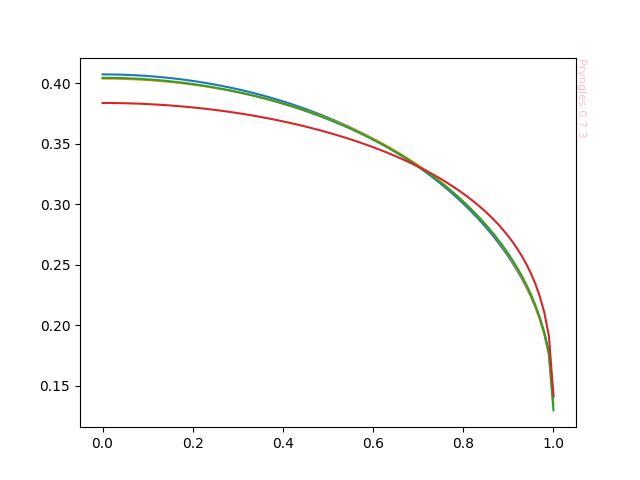

.

      VERB3::limb_darkening:: Normalization of limb darkening function for cs = [0.655], N = 2.45567825755602
      VERB3::limb_darkening:: Normalization of limb darkening function for cs = [0.6022, 0.0654], N = 2.4767269283350704
      VERB3::limb_darkening:: Normalization of limb darkening function for cs = [0.9724, -0.4962, 0.2029], N = 2.472665297844586
      VERB3::limb_darkening:: Normalization of limb darkening function for cs = [-0.2018, 2.1, -2.0247, 0.7567], N = 2.6067005991229735



----------------------------------------------------------------------
Ran 1 test in 0.078s

OK


In [105]:
if IN_JUPYTER:
    def test_limb(self):
        
        Verbose.VERBOSITY=VERB_ALL

        cs=[np.random.rand()]
        I=Science.limb_darkening(0.8,cs)
        print(I)
        
        fig=plt.figure()
        ax=fig.gca()

        rhos=np.linspace(0,1,100)
        coefs=[0.6550]
        ax.plot(rhos,Science.limb_darkening(rhos,coefs))
        coefs=[0.6022,0.0654]
        ax.plot(rhos,Science.limb_darkening(rhos,coefs))
        coefs=[0.9724,-0.4962,0.2029]
        ax.plot(rhos,Science.limb_darkening(rhos,coefs))    
        coefs=[-0.2018,2.1000,-2.0247,0.7567]
        ax.plot(rhos,Science.limb_darkening(rhos,coefs))
        Plot.pryngles_mark(ax)
        
        Verbose.VERBOSITY=VERB_NONE

    class Test(unittest.TestCase):pass
    Test.test_limb=test_limb
    unittest.main(argv=['first-arg-is-ignored'],exit=False)

--End--